# Exemple d'Intégration du Module AssistEye

Ce notebook montre comment utiliser les fonctionnalités de détection, visualisation, et API du module AssistEye.

In [1]:
import sys
import os

# Méthode d'indexation des modules AssistEye pour utiliser en dehors du dossier src
def configure():
    sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'src'))
    print(sys.path)

configure()

['/opt/anaconda3/envs/assisteye/lib/python39.zip', '/opt/anaconda3/envs/assisteye/lib/python3.9', '/opt/anaconda3/envs/assisteye/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/assisteye/lib/python3.9/site-packages', '/opt/anaconda3/envs/assisteye/lib/python3.9/site-packages/setuptools/_vendor', '/Users/quentinpierson/Documents/AssistEye-Module/src']


## Exemple : Chargement et Détection d'une Image

In [ ]:
# Importation des modules AssistEye
from AssistEye.detection import objectDetection

# Les modules sont déjà initialisés avec la configuration chargée automatiquement
# Vous pouvez directement utiliser les fonctions

# Exemple d'utilisation pour une image
image_path = 'bus.jpg'
annotations = {
    'class': True,
    'confidence': False,
    'distance': True,
}
objectDetection.run_inference(image_path, annotations)

## Exemple : Chargement et Détection d'une Video

In [ ]:
# Example usage for video
video_path = 'ville.mp4'
objectDetection.run_inference(video_path, annotations)

## Exemple : Détection de text sur un objet détecté

AssistEye config loaded successfully.
Initializing object detection model...
Model: yolo11n.pt, Device: mps


Using cache found in /Users/quentinpierson/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/quentinpierson/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


AssistEye module loaded successfully.
Original image:


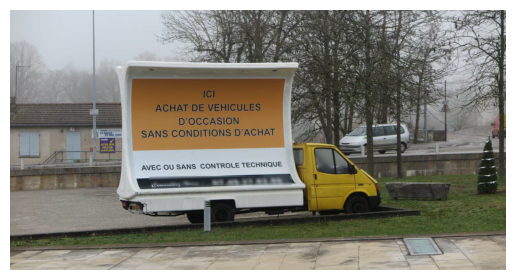


0: 352x640 1 car, 2 trucks, 411.9ms
Speed: 11.7ms preprocess, 411.9ms inference, 130.5ms postprocess per image at shape (1, 3, 352, 640)
Classifications: {'truck': 2, 'car': 1}
Positions: {'truck': [(258, 125, 896, 522), (258, 321, 898, 524)], 'car': [(795, 275, 968, 351)]}
Processing first region of class 'truck'...
Cropped image from the detected object:


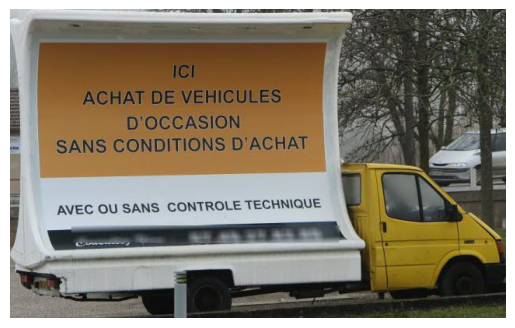

run text detection on the cropped image:
Detected text: ['AVEC', 'OU', 'SANS', 'CONTROLE', 'TECHNIQUE', '']
inference on cropped image with text detection:


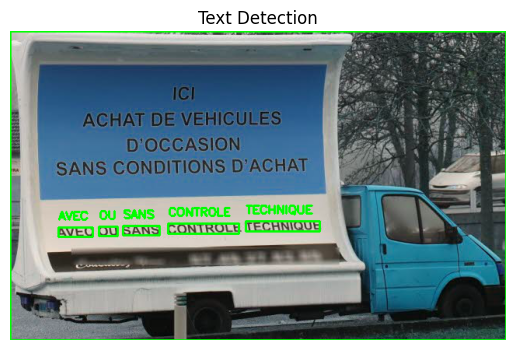

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from AssistEye.detection import objectDetection, textDetection

# Convert the image to a numpy array
image_path = 'truck.jpg'
image = np.array(Image.open(image_path))

# Show the image with plt
print("Original image:")
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

# Object detection
results = objectDetection.detect(image)
object_counts, distances, positions = objectDetection.process_results(results, depth_map_normalized=None, return_positions=True)

print("Classifications:", object_counts)
print("Positions:", positions)

# Crop the detected objects from the image
cropped_regions = objectDetection.crop_objects(image, positions)

if cropped_regions:
    for class_name, crops in cropped_regions.items():
        if crops:  # Vérifiez si la liste de régions recadrées n'est pas vide
            first_cropped_region = crops[0]  # Prendre la première région
            print(f"Processing first region of class '{class_name}'...")
            break
else:
    print("No regions were cropped.")

# Show the cropped image with plt
print("Cropped image from the detected object:")
plt.imshow(first_cropped_region)
plt.axis('off')  # Hide the axis
plt.show()

# Text detection
print("run text detection on the cropped image:")
text_results = textDetection.detect(first_cropped_region)
detected_text, text_positions = textDetection.process_results(text_results)

print("Detected text:", detected_text)

annotations = {
    'class': True,
    'confidence': True
}

# Run inference on the cropped region
print("inference on cropped image with text detection:")
textDetection.run_inference(first_cropped_region, annotations)

## Configuration des modules 



In [ ]:
from ultralytics import YOLO
from AssistEye import detection
from AssistEye.detection import objectDetection

# Calling the init function to initialize the modules with custom configuration
model_name = 'yolo8n.pt' # Custom model 
device_name = 'mps' # Custom device "cpu", "cuda", "mps"

objectDetection.initialization(model_name, device_name)

image = 'bus.jpg'

# Running the inference
objectDetection.run_inference(image, annotations)

## Utilisation du bandeau de débogage

In [ ]:
# Génération et affichage du bandeau de débogage
debug_info = debug.generate_debug_info(results)
print(debug_info)


## Utilisation de l'API AssistEye

In [ ]:
# Démarrage de l'API
api = API(config_path)
api.start_server()


# Utilisation des commandes

## Mettre a jour un paramètre de configuration

Lorsque vous souhaitez mettre à jour un paramètre et obtenir la réponse. Peux être combiné au TTS et SST pour permettre a un utilisateur de modifier une configuration en utilisant uniquement sa voix.

In [ ]:
from AssistEye import config

# Exemple de mise à jour du paramètre 'language' dans la section 'general'
message = config.update_config_param('general', 'language', 'en')
print(message)